# 04.2 - Width Investigation

The second subsection of the architecture investigation focuses on varying the width of the network (by which I mean the number of nodes per layer), while keeping the depth constant (there are always three hidden layers in this subsection). We consider six cases:

* 1 node per layer (a degenerate case)
* 2 nodes per layer
* 3 nodes per layer
* 5 nodes per layer
* 10 nodes per layer
* 100 nodes per layer

The first things we do are to import all the necessary libraries and functions, load and process our dataset, and set up functions to create our neural networks. There will be no further commentary here on these - the code here is identical to that in section 3.

In [1]:
import time
import json

import random as python_random
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.metrics import TruePositives
from tensorflow.keras.metrics import KLDivergence

from mlxtend.plotting import plot_confusion_matrix

#for reproducibility, we set random seeds here
#Jupyter can sometimes assign seed value only in the cell that the random seed is called
#you can change this rseed value so the entire notebook changes seed values
rseed = 42

np.random.seed(rseed)
python_random.seed(rseed)
tf.random.set_seed(rseed)

In [2]:
#load the dataframes created in the Data.ipynb section
X_train = pd.read_csv('..\data\X_train.csv')
X_val = pd.read_csv('..\data\X_val.csv')
X_test = pd.read_csv('..\data\X_test.csv')

y_train_bin = pd.read_csv('..\data\y_train_bin.csv')
y_val_bin = pd.read_csv('..\data\y_val_bin.csv')
y_test_bin = pd.read_csv('..\data\y_test_bin.csv')

y_train_multi = pd.read_csv('..\data\y_train_multi.csv')
y_val_multi = pd.read_csv('..\data\y_val_multi.csv')
y_test_multi = pd.read_csv('..\data\y_test_multi.csv')

In [3]:
#turn string labels into float categories, categs is list of categories
y_train_multi, categs = pd.factorize(y_train_multi.connection_category)
y_val_multi, categs = pd.factorize(y_val_multi.connection_category)
y_test_multi, categs = pd.factorize(y_test_multi.connection_category)
#turn float categories into tf.keras matrix categories of dimension length(categs)
#e.g. 'normal' = [1,0,0,0,0]
y_train_multi = to_categorical(y_train_multi, num_classes = len(categs))
y_val_multi = to_categorical(y_val_multi, num_classes = len(categs))
y_test_multi = to_categorical(y_test_multi, num_classes = len(categs))

In [4]:
def binaryDNN(train_df = X_train, hidden_nodes = [10,10,10], op = 'adam', metrics = [tf.keras.metrics.AUC()]):
    '''
    Function that takes dataframe train_df and creates a binary classifer neural network 
    with single node sigmoid output
    
    train_df = dataframe or array 
    hidden_nodes = list of nodes in each layer e.g. [10,10] will create a neural network
                   with input layers equal to the number of input variables, a first hidden layer
                   with 10 nodes, and a second hidden layer with 10 nodes, with a final output
                   layer with a single node.
    op = string name of optimizer e.g. 'adam', or tf.keras.optimizers instance.
    metrics = list of metrics to be evaluated by the model, can be string, function, or tf.keras.metrics.Metric instance
    '''
    
    nn_model = Sequential()
    #input dimensions
    nn_model.add(Input(shape = (train_df.shape[1],)))
    
    #add layers 
    for i in hidden_nodes:
        #we use 'relu' as good, safe default for our neural nets
        nn_model.add(Dense(i, activation = 'relu'))
        
    #output layer
    nn_model.add(Dense(1, activation = 'sigmoid'))
    
    #compile model
    nn_model.compile(loss='binary_crossentropy',optimizer=op,metrics=metrics)
    
    return nn_model

 

def multiDNN(train_df = X_train, num_classes = 5, hidden_nodes = [10,10,10], op = 'adam', 
             c_metrics = ['accuracy',TruePositives(),tfa.metrics.CohenKappa(num_classes=5)]):
    
    '''
    Function that takes dataframe train_df and creates a multiclass classifer neural network 
    with softmax output layers equal to the number of classes passed
    
    train_df = dataframe or array 
    num_classes = int, number of classes in the dataset
    hidden_nodes = list of nodes in each layer e.g. [10,10] will create a neural network
                   with input layers equal to the number of input variables, a first hidden layer
                   with 10 nodes, and a second hidden layer with 10 nodes, with a final 
                   output layer containing num_classes softmax nodes
    op = string name of optimizer e.g. 'adam', or tf.keras.optimizers instance.
    c_metrics = list of metrics to be evaluated by the model, can be string, function, or tf.keras.metrics.Metric instance
    '''
    
    #we initiate our model differently here, taking layers as a list
    #this is because of some issues when implementing when creating a neural net as above
    layers = []
    #input dimensions
    layers.append(Input(shape = (train_df.shape[1],)))
    
    #add layers with dropout
    for i in hidden_nodes:
        layers.append(Dense(i, activation = 'relu'))
        layers.append(Dropout(0.2))
        
    #output layer with number of nodes = num_classes
    layers.append(Dense(num_classes, activation = 'softmax'))
    
    nn_model = Sequential(layers)
    #compile model
    nn_model.compile(loss='categorical_crossentropy',optimizer=op,metrics=c_metrics)
    
    return nn_model

In [5]:
tf.random.set_seed(rseed)

count = 1
epochs = 30
batch_size = 500

x1 = -np.arange(1,5)
epsilons = np.float_power(10,x1)

widths = [1, 2, 3, 5, 10, 100]

bin_models = []
bin_history = []
categ_models = []
categ_history = []

i = 0
for width in widths:

    nodes = [width]*3
    
    bin_models.append([])
    bin_history.append([])
    categ_models.append([])
    categ_history.append([])
    
    j = 0
    for eps in epsilons:

        optimizer = tf.keras.optimizers.SGD(learning_rate = eps, nesterov = False)
  
        bin_model_temp = binaryDNN(op = optimizer, hidden_nodes=nodes)
    
        print('-'*10 + 'Fitting binary model to sgd optimizer with learning rate {} and {} width'.format(eps,width) + '-'*10)
        start = time.time()
        bin_history_temp = bin_model_temp.fit(X_train, y_train_bin, shuffle = True, validation_data = (X_val, y_val_bin), epochs = epochs, batch_size = batch_size, verbose = 0)
        end = time.time()
        print('Time taken: {} seconds'.format(end - start))

        bin_models[i].append(bin_model_temp)
        bin_history[i].append(bin_history_temp)

        categ_model_temp = multiDNN(op = optimizer, hidden_nodes=nodes)
        print('-'*10 + 'Fitting categorical model to sgd optimizer with learning rate {} and {} width'.format(eps,width) + '-'*10)
        start = time.time()
        categ_history_temp = categ_model_temp.fit(X_train, y_train_multi, shuffle = True, validation_data = (X_val, y_val_multi), epochs = epochs, batch_size = batch_size, verbose = 0)
        end = time.time()
        print('Time taken: {} seconds'.format(end - start))

        categ_models[i].append(categ_model_temp)
        categ_history[i].append(categ_history_temp)

        #delete temp model and history to free up memory
        del bin_model_temp
        del bin_history_temp
        del categ_model_temp
        del categ_history_temp
        print()

        j += 1
        
    i += 1

----------Fitting binary model to sgd optimizer with learning rate 0.1 and 1 width----------
Time taken: 59.93172359466553 seconds
----------Fitting categorical model to sgd optimizer with learning rate 0.1 and 1 width----------
Time taken: 104.71857023239136 seconds

----------Fitting binary model to sgd optimizer with learning rate 0.01 and 1 width----------
Time taken: 58.805192947387695 seconds
----------Fitting categorical model to sgd optimizer with learning rate 0.01 and 1 width----------
Time taken: 110.50037956237793 seconds

----------Fitting binary model to sgd optimizer with learning rate 0.001 and 1 width----------
Time taken: 64.39102602005005 seconds
----------Fitting categorical model to sgd optimizer with learning rate 0.001 and 1 width----------
Time taken: 107.06293511390686 seconds

----------Fitting binary model to sgd optimizer with learning rate 0.0001 and 1 width----------
Time taken: 60.335575580596924 seconds
----------Fitting categorical model to sgd optimize

Now that we have trained our networks, we save the trained models and their histories to disk so that we do not need to rerun the training if we have to restart the kernel for whatever reason. (you probably don't need to run this block - it takes quite a while, and you shouldn't need to use it)

In [8]:
#create a folder called saved_models and one called saved_hists to prevent saving errors
!mkdir saved_models saved_hists

for i in range(len(widths)):
    for j in range(len(epsilons)):
        bin_models[i][j].save('saved_models/width_bin_{}_{}'.format(widths[i], epsilons[j]))
        categ_models[i][j].save('saved_models/width_categ_{}_{}'.format(widths[i], epsilons[j]))

        #call .history and dump using json
        json.dump(bin_history[i][j].history, open('saved_hists/width_bin_{}_{}'.format(widths[i], epsilons[j]), 'w'))
        json.dump(categ_history[i][j].history, open('saved_hists/width_categ_{}_{}'.format(widths[i], epsilons[j]), 'w'))

A subdirectory or file saved_models already exists.
Error occurred while processing: saved_models.
A subdirectory or file saved_hists already exists.
Error occurred while processing: saved_hists.


INFO:tensorflow:Assets written to: saved_models/width_bin_1_0.1\assets
INFO:tensorflow:Assets written to: saved_models/width_categ_1_0.1\assets
INFO:tensorflow:Assets written to: saved_models/width_bin_1_0.01\assets
INFO:tensorflow:Assets written to: saved_models/width_categ_1_0.01\assets
INFO:tensorflow:Assets written to: saved_models/width_bin_1_0.001\assets
INFO:tensorflow:Assets written to: saved_models/width_categ_1_0.001\assets
INFO:tensorflow:Assets written to: saved_models/width_bin_1_0.0001\assets
INFO:tensorflow:Assets written to: saved_models/width_categ_1_0.0001\assets
INFO:tensorflow:Assets written to: saved_models/width_bin_2_0.1\assets
INFO:tensorflow:Assets written to: saved_models/width_categ_2_0.1\assets
INFO:tensorflow:Assets written to: saved_models/width_bin_2_0.01\assets
INFO:tensorflow:Assets written to: saved_models/width_categ_2_0.01\assets
INFO:tensorflow:Assets written to: saved_models/width_bin_2_0.001\assets
INFO:tensorflow:Assets written to: saved_models/w

We now have a large number of trained models. Investigating them all simultaneously would be futile, so for each learning rate we will compare the models trained with that rate.

## $\varepsilon = 0.1$

### Binary Classification

First, we examine the loss functions of each of the models and observe how they changed accross the 30 epochs (note: this is the loss as computed on the verification set, not the training set).

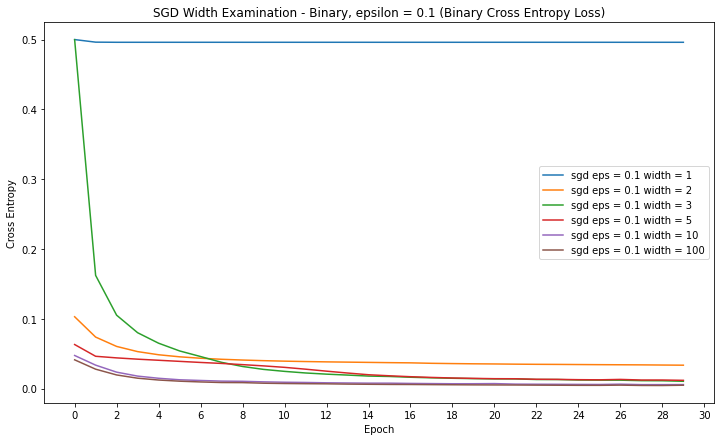

In [10]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Width Examination - Binary, epsilon = 0.1 (Binary Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for i in range(len(widths)):
    plt.plot(bin_history[i][0].history['val_loss'],label='sgd eps = 0.1 width = {}'.format(widths[i]))

plt.legend()
plt.show()

Unsurprisingly, the width 1 case produces no worthwhile results - such a 'network' doesn't really have any of the structure which makes a neural net function, so it fails to do anything of value. It will be removed from future graphs. I will also cut the first epoch off this graph, to aid in getting a better look at the other curves (note that the x-axis labels on the resulting grah will be off-by-one).

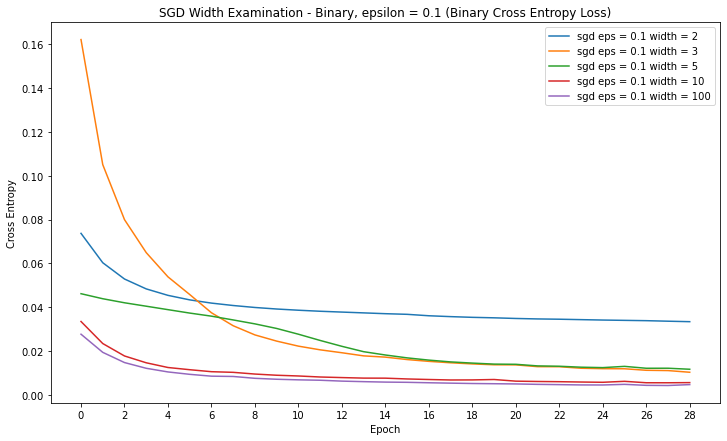

In [19]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Width Examination - Binary, epsilon = 0.1 (Binary Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for i in range(1, len(widths)):
    plt.plot(bin_history[i][0].history['val_loss'][1:],label='sgd eps = 0.1 width = {}'.format(widths[i]))

plt.legend()
plt.show()

Here we see that the loss conveges quite quickly for all non-degenerate widths. However, it converges to a lower value the higher the width is - 2 width is particularly bad, while there's almost no difference between 10 and 100.

Next, we plot the AUC metric instead of the loss:

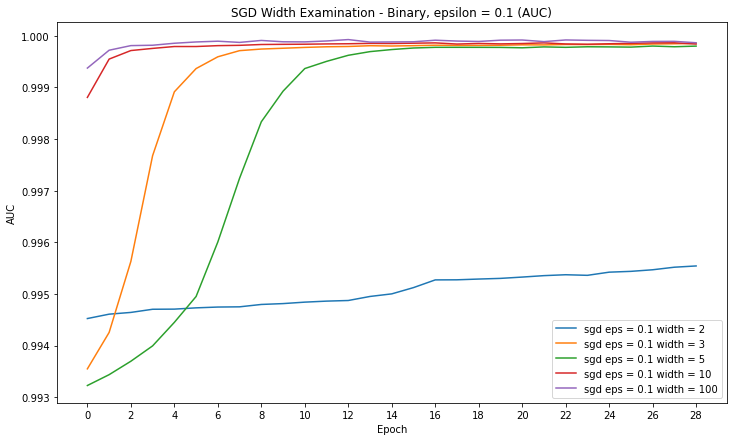

In [34]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Width Examination - Binary, epsilon = 0.1 (AUC)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('AUC')

for i in range(1, len(widths)):
    plt.plot(bin_history[i][0].history['val_auc'][1:],label='sgd eps = 0.1 width = {}'.format(widths[i]))

plt.legend()
plt.show()

We see that for all cases with n > 2, a very high AUC score is reached and the only real difference appears to be the speed of convergence. At n = 2, the AUC attained is much lower - although it's not clear whether this is because the value converged to is lower or if convergence is just very slow.

Now we compare confusion matrices:

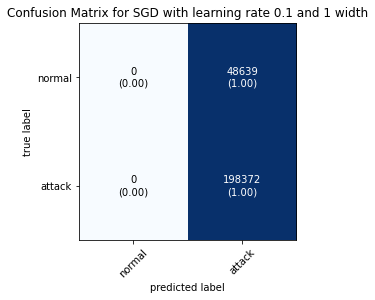

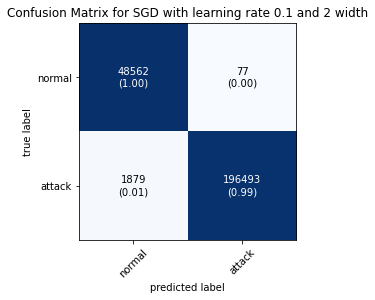

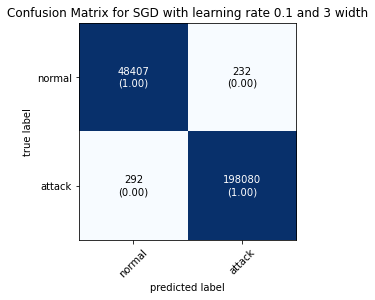

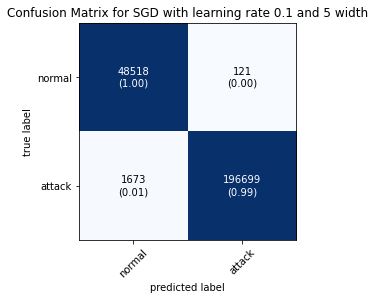

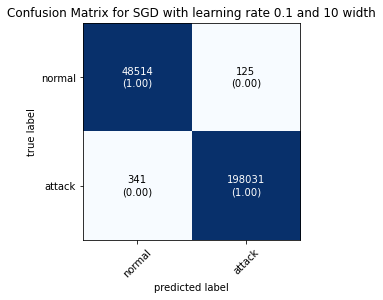

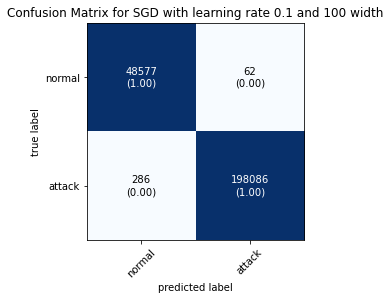

In [23]:
def plot_cmat_bin(model, i, j):
    pred = model.predict(X_test)
    pred = [round(x[0]) for x in pred]
    
    cmat = confusion_matrix(y_test_bin,pred)
    
    plot_confusion_matrix(conf_mat=cmat, show_normed=True, class_names=['normal','attack'])
    
    plt.title('Confusion Matrix for SGD with learning rate {} and {} width'.format(epsilons[j], widths[i]))
    
plot_cmat_bin(bin_models[0][0], 0, 0)
plot_cmat_bin(bin_models[1][0], 1, 0)
plot_cmat_bin(bin_models[2][0], 2, 0)
plot_cmat_bin(bin_models[3][0], 3, 0)
plot_cmat_bin(bin_models[4][0], 4, 0)
plot_cmat_bin(bin_models[5][0], 5, 0)

We see immediately that classification is very good in every case except width = 1, as expected. For the most part we see that performance improves as the width increases, although the increases are slight. There is something strange going on, though - the confusion matrices for widths 2 and 5 indicate a strong bias for false negatives over false positives, which isn't present in any of the others. I suspect this is just down to random traits of the trained network, but it *is* puzzling.

## Multi-class Classification

Again, we plot the loss functions:

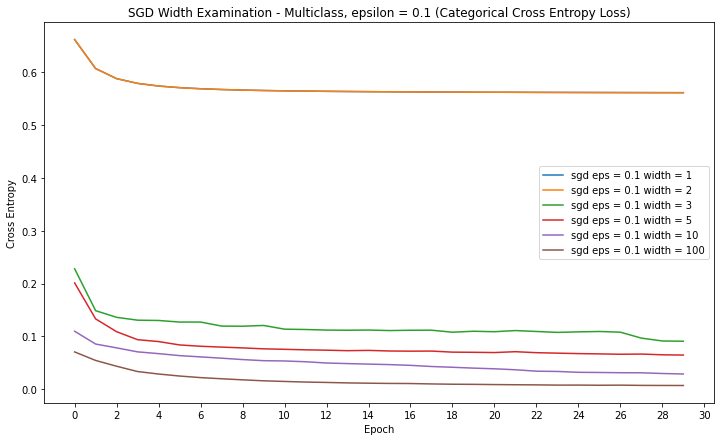

In [26]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Width Examination - Multiclass, epsilon = 0.1 (Categorical Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for i in range(len(widths)):
    plt.plot(categ_history[i][0].history['val_loss'],label='sgd eps = 0.1 width = {}'.format(widths[i]))

plt.legend()
plt.show()

In this multiclass case, we again see that width = 1 gives useless results. The difference is that width = 2 is also worthless here (the lines overlap eachother on the graph). So, we plot this again but without either of them.

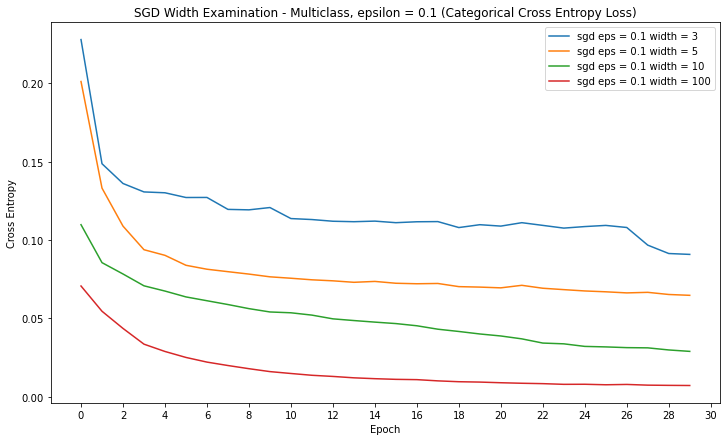

In [27]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Width Examination - Multiclass, epsilon = 0.1 (Categorical Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for i in range(2, len(widths)):
    plt.plot(categ_history[i][0].history['val_loss'],label='sgd eps = 0.1 width = {}'.format(widths[i]))

plt.legend()
plt.show()

Here we see that the width affects the level to which the loss converges, but it does not seem to actually affect the rate of convergence. To get a better idea of what's going on, we plot the accuracy (first epoch is trimmed to make the graph readable):

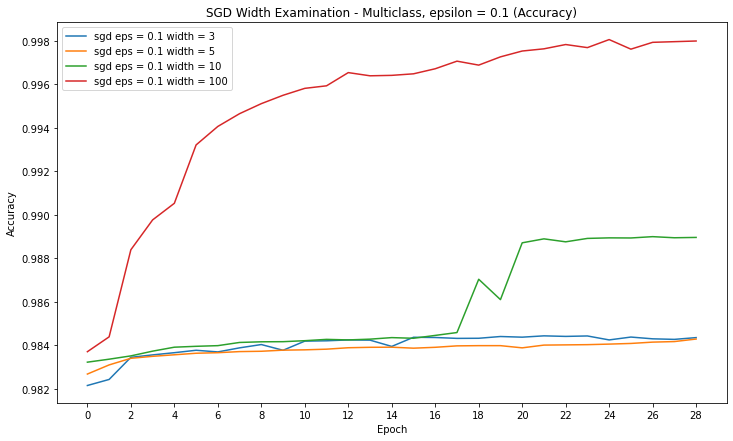

In [35]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Width Examination - Multiclass, epsilon = 0.1 (Accuracy)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Accuracy')

for i in range(2, len(widths)):
    plt.plot(categ_history[i][0].history['val_accuracy'][1:],label='sgd eps = 0.1 width = {}'.format(widths[i]))

plt.legend()
plt.show()

We see here that despite the width = 3 and width = 5 cases' loss functions seeming to converge to quite different values, their performance seems to be about the same (based on accuracy). To get an even better picture, we compare confusion matrices:

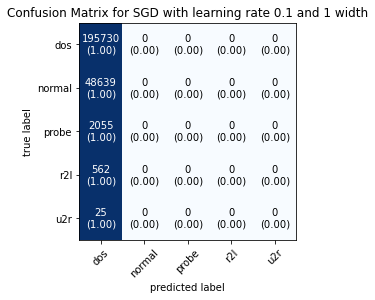

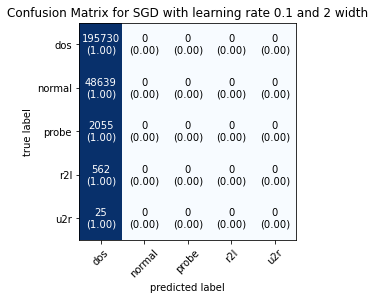

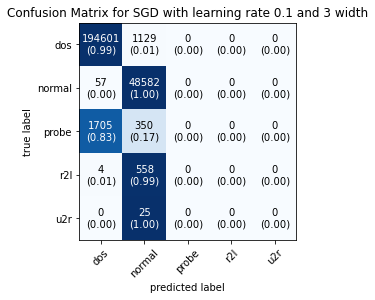

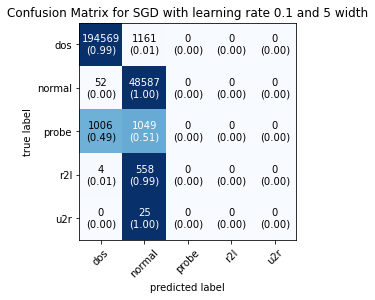

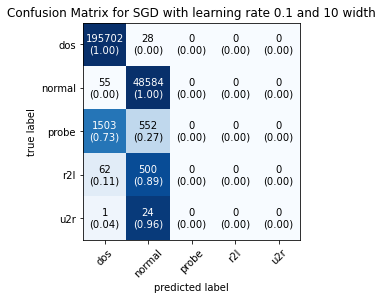

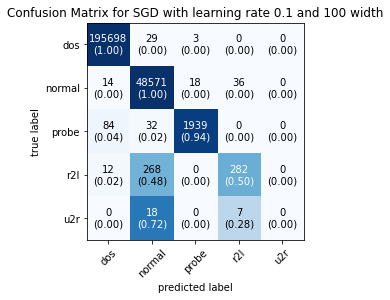

In [30]:
def plot_cmat_categ(model, i, j):
    pred = model.predict(X_test)
    
    cmat = confusion_matrix(tf.argmax(y_test_multi,axis=1),tf.argmax(pred,axis=1))
    
    plot_confusion_matrix(conf_mat=cmat, show_normed=True, class_names=categs)
    
    plt.title('Confusion Matrix for SGD with learning rate {} and {} width'.format(epsilons[j], widths[i]))
    
plot_cmat_categ(categ_models[0][0], 0, 0)
plot_cmat_categ(categ_models[1][0], 1, 0)
plot_cmat_categ(categ_models[2][0], 2, 0)
plot_cmat_categ(categ_models[3][0], 3, 0)
plot_cmat_categ(categ_models[4][0], 4, 0)
plot_cmat_categ(categ_models[5][0], 5, 0)

This now paints a fairly clear picture of what is going on:

* Width 1 and 2 are useless, they underfit catastrophically
* Width 3 and 5 are aobut the same - the only significant difference is in the way that they miscategorise probe attacks
* Width 10 performs a bit better, but not by much - it misclassifies DoS attacks as normal at a much lower rate
* Width 100 is a big improvement - the model becomes able to recognise probe attacks reliably and R2L attacks sometimes (when they were never predicted beforehand). U2R attacks remain elusive.

Knowing this, the obvious choice of width to use in future sections would be 100. However, we in fact chose to stick with our original choice of 10. This is because of some technical issues which we had had - previous versions of this work had indicated that there would be little advantage in increasing the width above 10, due to a bug in my implementation.

We now do some investigation of lower learning rates, though this is of less importance.

## $\varepsilon = 0.01$

We plot each of the loss/metric graphs:

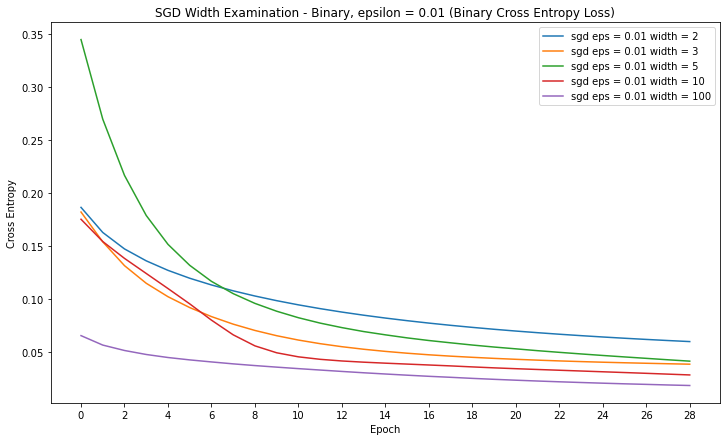

In [32]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Width Examination - Binary, epsilon = 0.01 (Binary Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for i in range(1, len(widths)):
    plt.plot(bin_history[i][1].history['val_loss'][1:],label='sgd eps = 0.01 width = {}'.format(widths[i]))

plt.legend()
plt.show()

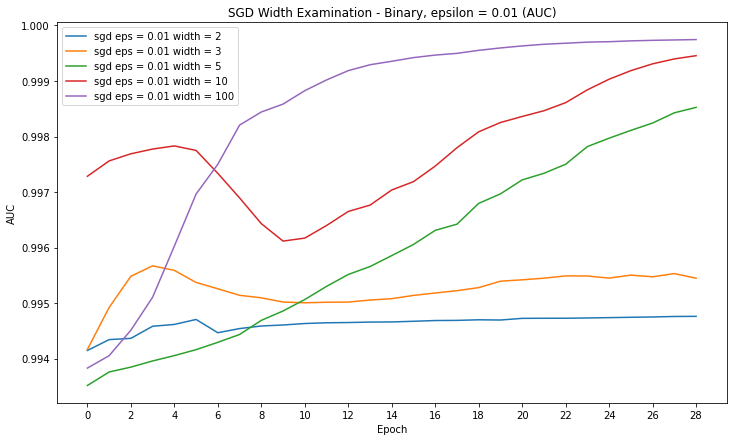

In [41]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Width Examination - Binary, epsilon = 0.01 (AUC)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('AUC')

for i in range(1, len(widths)):
    plt.plot(bin_history[i][1].history['val_auc'][1:],label='sgd eps = 0.01 width = {}'.format(widths[i]))

plt.legend()
plt.show()

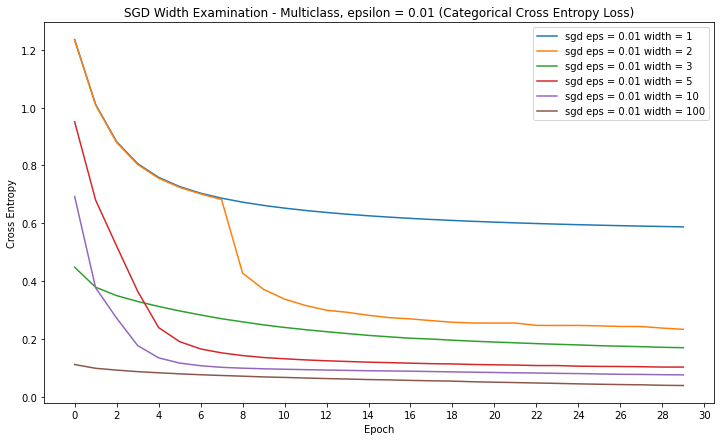

In [39]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Width Examination - Multiclass, epsilon = 0.01 (Categorical Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for i in range(0, len(widths)):
    plt.plot(categ_history[i][1].history['val_loss'],label='sgd eps = 0.01 width = {}'.format(widths[i]))

plt.legend()
plt.show()

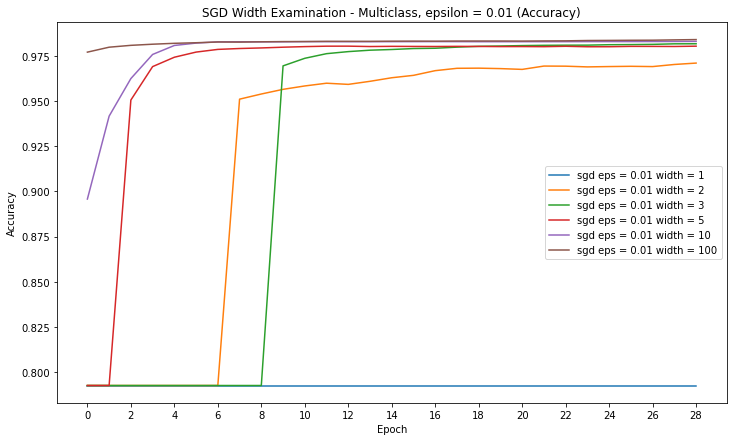

In [77]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Width Examination - Multiclass, epsilon = 0.01 (Accuracy)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Accuracy')

for i in range(0, len(widths)):
    plt.plot(categ_history[i][1].history['val_accuracy'][1:],label='sgd eps = 0.01 width = {}'.format(widths[i]))

plt.legend()
plt.show()

In the binary case here, we see that the final result after 30 epochs improves as the width increases, but the rate of convergence doesn't change very much (and to the extent that it does change, it does so unpredictably). Interestingly, there is a period of several epochs where the AUC for the width = 10 case decreases over time. This isn't really surprising, though - the training process is not trying to optimise AUC, so there's no reason why it shouldn't decrease sometimes (it's not usually this dramatic, though).

We get a similar result in the multiclass case, though what's interesting is the accuracy graph - it indicates that each choice of width (except for the best two) has the classifier predict everything as a DoS attack until a certain point, then quite rapidly learn to recognise regular traffic. This is another case where the network is learning despite the fact that the classification accuracy is constant.

## $\varepsilon = 0.001$

Again, we plot each of the loss/metric graphs:

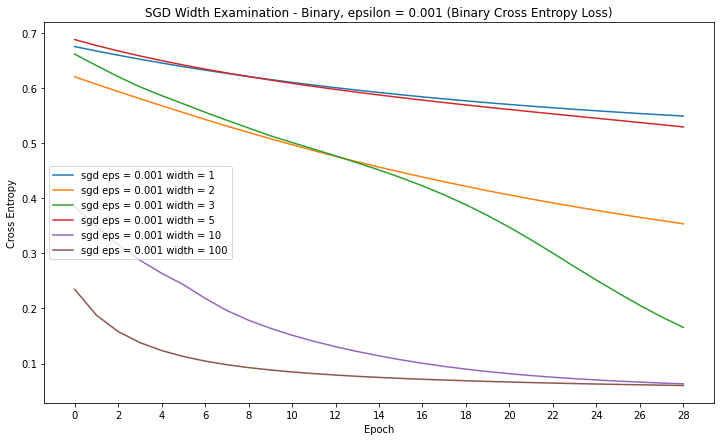

In [58]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Width Examination - Binary, epsilon = 0.001 (Binary Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for i in range(0, len(widths)):
    plt.plot(bin_history[i][2].history['val_loss'][1:],label='sgd eps = 0.001 width = {}'.format(widths[i]))

plt.legend()
plt.show()

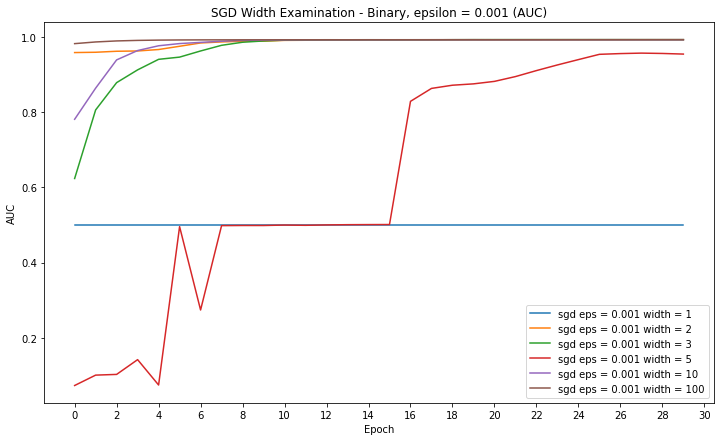

In [64]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Width Examination - Binary, epsilon = 0.001 (AUC)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('AUC')

for i in range(0, len(widths)):
    plt.plot(bin_history[i][2].history['val_auc'][0:],label='sgd eps = 0.001 width = {}'.format(widths[i]))

plt.legend()
plt.show()

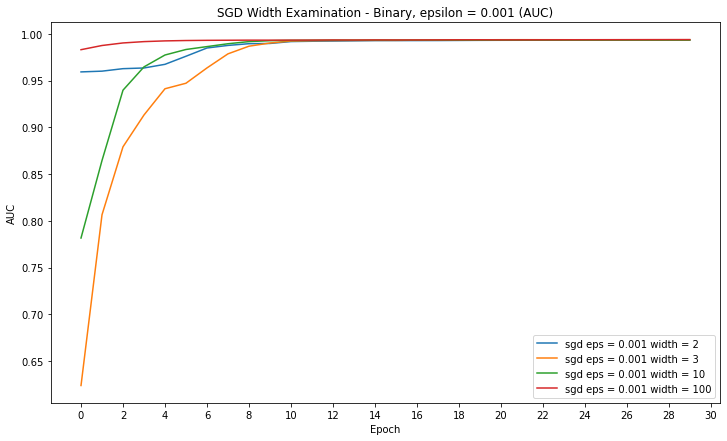

In [72]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Width Examination - Binary, epsilon = 0.001 (AUC)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('AUC')

for i in [1, 2, 4, 5]:
    plt.plot(bin_history[i][2].history['val_auc'][0:],label='sgd eps = 0.001 width = {}'.format(widths[i]))

plt.legend()
plt.show()

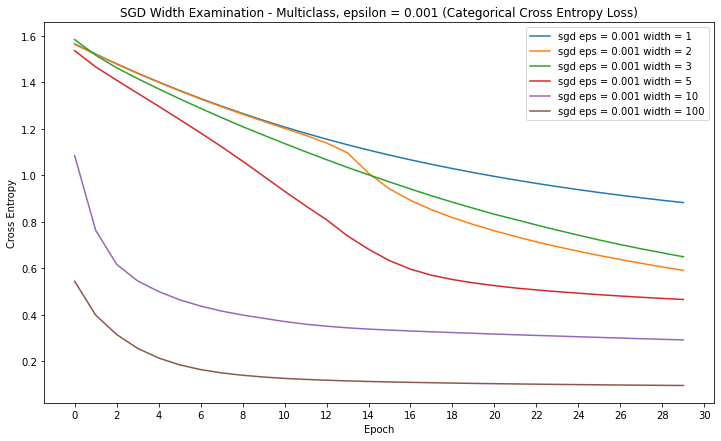

In [75]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Width Examination - Multiclass, epsilon = 0.001 (Categorical Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for i in range(0, len(widths)):
    plt.plot(categ_history[i][2].history['val_loss'],label='sgd eps = 0.001 width = {}'.format(widths[i]))

plt.legend()
plt.show()

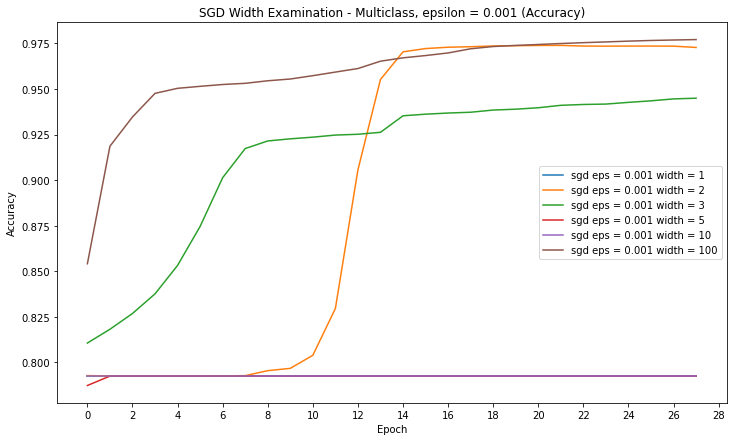

In [102]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Width Examination - Multiclass, epsilon = 0.001 (Accuracy)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Accuracy')

for i in range(0, len(widths)):
    plt.plot(categ_history[i][2].history['val_accuracy'][2:],label='sgd eps = 0.001 width = {}'.format(widths[i]))

plt.legend()
plt.show()

At this point we are starting to get some frankly bizarre results. In the binary case, all seems mostly normal - every width > 1 seems to converge to the same point, with the width affecting only the rate of convergence (in a non-obvious way). The exception is width = 5, which gives weirdly terrible results that I have no explanation for.

Similarly strange - in the multiclass case, we get what looks like a sensible graph of the loss function, showing that different widths converge to different levels at about the same rate, and that these levels come in the expected order.

The issue comes in the accuracy graph, where we see that apparently the width = 10 and width = 5 nets both predict everything to be DoS all the time, when the width = 2/3 nets escape this fate. Again, I have no explanation for this.

## $\varepsilon = 0.0001$

For the last time, we plot each of the loss/metric graphs:

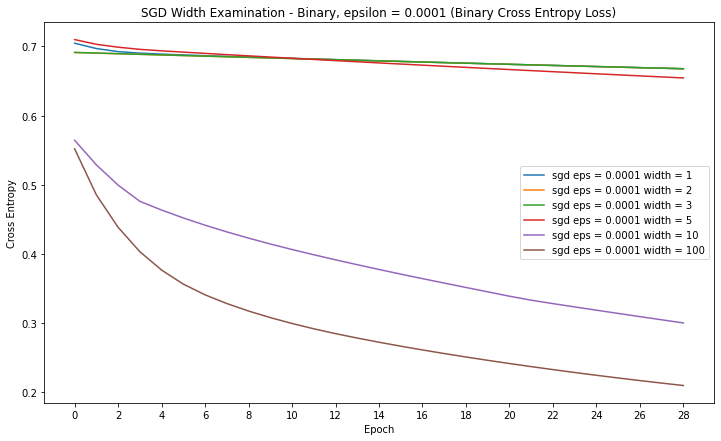

In [103]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Width Examination - Binary, epsilon = 0.0001 (Binary Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for i in range(0, len(widths)):
    plt.plot(bin_history[i][3].history['val_loss'][1:],label='sgd eps = 0.0001 width = {}'.format(widths[i]))

plt.legend()
plt.show()

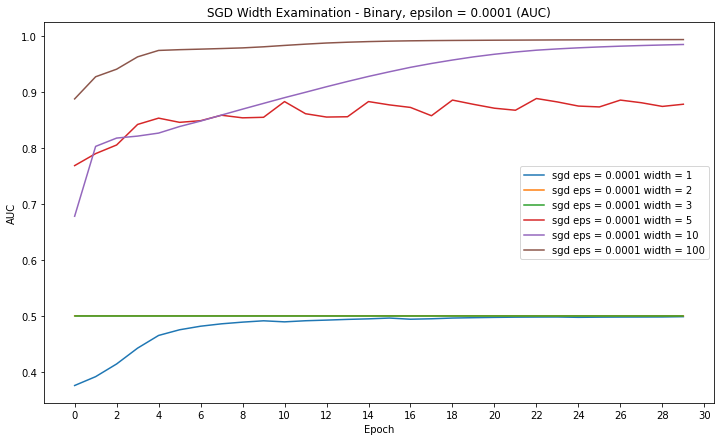

In [106]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Width Examination - Binary, epsilon = 0.0001 (AUC)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('AUC')

for i in range(0, len(widths)):
    plt.plot(bin_history[i][3].history['val_auc'][0:],label='sgd eps = 0.0001 width = {}'.format(widths[i]))

plt.legend()
plt.show()

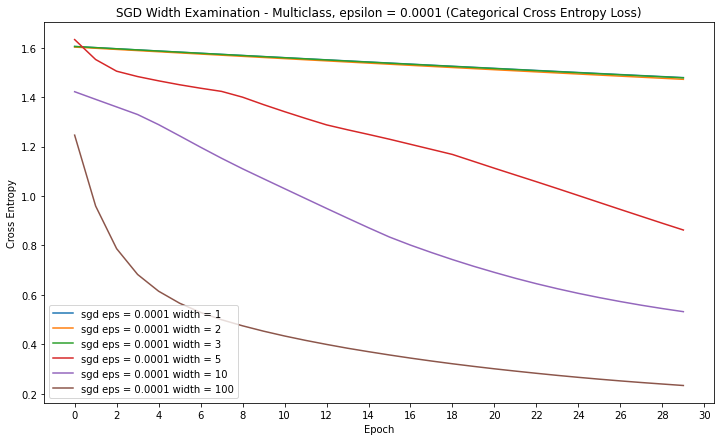

In [107]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Width Examination - Multiclass, epsilon = 0.0001 (Categorical Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for i in range(0, len(widths)):
    plt.plot(categ_history[i][3].history['val_loss'],label='sgd eps = 0.0001 width = {}'.format(widths[i]))

plt.legend()
plt.show()

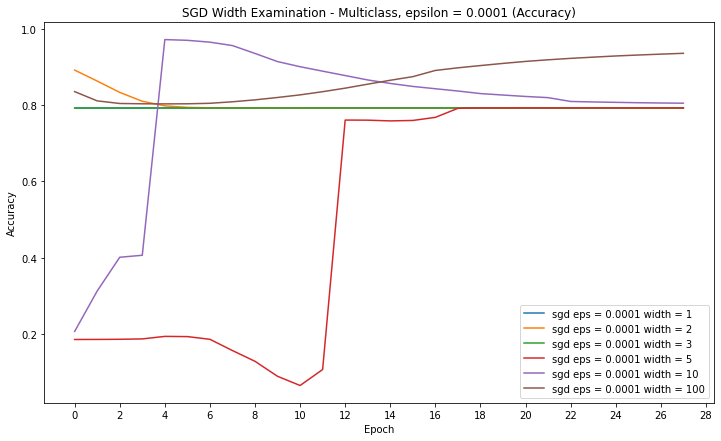

In [109]:
fig = plt.figure(figsize=(12,7))

plt.title('SGD Width Examination - Multiclass, epsilon = 0.0001 (Accuracy)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Accuracy')

for i in range(0, len(widths)):
    plt.plot(categ_history[i][3].history['val_accuracy'][2:],label='sgd eps = 0.0001 width = {}'.format(widths[i]))

plt.legend()
plt.show()

Finally: in the binary case here, the loss plot shows that only the width = 10/100 networks are very successful at learning anything at all, although the AUC plot shows that the weight = 5 net has managed to learn *something*, but it's a far weaker classifer than one would expect from a neural net.

On the other hand, in the multiclass case it's apparent from the accuracy that every network except for the width = 100 net converges to reporting everything as DoS, and is therefore useless.